# Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.data import AUTOTUNE
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D, SpatialDropout2D, BatchNormalization, ReLU, Add

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Denoising Autoencoder - CelebA

Visualizar o encoding e decoding de rostos humanos, usando um autoencoder de remoção de ruído e o dataset CelebA (+200.000 amostras) \
Dataset disponível em: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [5]:
# Carregamento do dataset via arquivo zip
caminho_arquivo = '/content/drive/MyDrive/projetos/celebA_autoencoders/CelebA_images.zip'
pasta_destino = '/content/CelebA_dataset'

with zipfile.ZipFile(caminho_arquivo, 'r') as z:
  z.extractall(pasta_destino)

In [88]:
# Divisão em base de treino e validação
full_train = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='training',
    batch_size=16,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

val_ds = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='validation',
    batch_size=16,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

# Pegando parte do treino como teste
test_size = 0.2
test_ds = full_train.take(int(len(full_train) * test_size))
train_ds = full_train.skip(int(len(full_train) * test_size))

# Treino -> 72%
# Teste  -> 18%
# Val    -> 10%

Found 202599 files.
Using 182340 files for training.
Found 202599 files.
Using 20259 files for validation.


In [89]:
print('- ' * 10)
print(f'{int(len(train_ds) * 16)} - {int(len(train_ds) * 16) / 202599:.2%}')
print(f'{int(len(test_ds) * 16)} - {int(len(test_ds) * 16) / 202599:.2%}')
print(f'{int(len(val_ds) * 16)} - {int(len(val_ds) * 16) / 202599:.2%}')

- - - - - - - - - - 
145888 - 72.01%
36464 - 18.00%
20272 - 10.01%


## Normalização dos valores

In [90]:
def normaliza_ds(image):
  image = tf.cast(image, tf.float32) / 255
  return image

train_ds = train_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = test_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [91]:
print(next(iter(train_ds.take(1))).shape)
print(next(iter(test_ds.take(1))).shape)
print(next(iter(val_ds.take(1))).shape)

(16, 176, 216, 3)
(16, 176, 216, 3)
(16, 176, 216, 3)


## Dataset no formato (image, image)

In [92]:
train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

##  Adição de ruído nas imagems

In [93]:
# Aplica ruido gaussiano entre 0.0 e 0.4 para aumentar robustez
def add_gaussian_noise(x, y, start=.0, end=.4):
  std = tf.random.uniform(shape=[], minval=start, maxval=end)
  noise = tf.random.normal(shape=tf.shape(x), mean=.0, stddev=std)
  x = y
  x = tf.clip_by_value(x+noise, 0., 1.)
  return x, y

In [94]:
train_ds = train_ds.map(add_gaussian_noise)
test_ds = test_ds.map(add_gaussian_noise)
val_ds = val_ds.map(add_gaussian_noise)

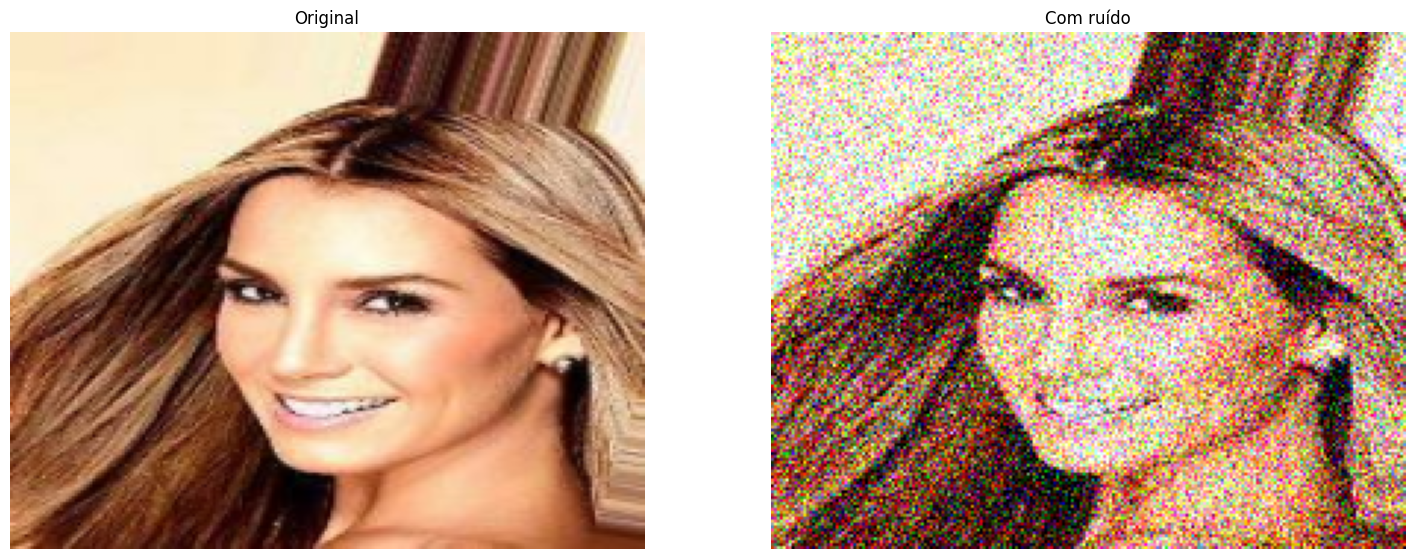

In [95]:
noisy, image = next(iter(test_ds.unbatch().take(1)))
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy)
plt.title('Com ruído')
plt.axis('off');

## Loss function customizada

In [96]:
# Definição de uma loss que combina MSE + SSIM (Structural similarity index measure)
def mse_ssim(y_true, y_pred):
  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.))
  return .9*mse + .1*ssim

## Blocos residuais (ResNet)

In [97]:
def residual_block(x_in, filters, kernel_size=3):
  shortcut = x_in

  # 1a conv
  x = Conv2D(filters, kernel_size, padding='same')(x_in)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # 2a conv
  x = Conv2D(filters, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)

  # Adição e ativação
  x = Add()([x, shortcut])
  x = ReLU()(x)

  return x

## Definição do Denoising Autoencoder

In [98]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [99]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=.5,
)

In [100]:
# Entrada
inp = Input(shape=(176, 216, 3))


# --- Encoder ---
x = Conv2D(32, (3,3), padding='same')(inp)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(.2)(x)
x = residual_block(x, 32) # <-- Bloco residual
x = MaxPool2D()(x)

x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(.2)(x)
x = residual_block(x, 64) # <-- Bloco residual
x = MaxPool2D()(x)

x = Conv2D(128, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(.2)(x)
x = residual_block(x, 128) # <-- Bloco residual

encoded = MaxPool2D()(x)

# --- Decoder ---
x = Conv2D(128, (3,3), padding='same')(encoded)
x = BatchNormalization()(x)
x = ReLU()(x)
x = residual_block(x, 128) # <-- Bloco residual
x = UpSampling2D()(x)

x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = residual_block(x, 64) # <-- Bloco residual
x = UpSampling2D()(x)

x = Conv2D(32, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = residual_block(x, 32) # <-- Bloco residual
x = UpSampling2D()(x)


# Saída
out = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)

In [101]:
# Definição do modelo
denoising_autoencoder = Model(inputs=inp, outputs=out)

In [102]:
denoising_autoencoder.compile(optimizer='adam', loss=mse_ssim)

In [103]:
denoising_autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 176, 216,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 176, 216,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 216,  │        128 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 176, 216,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 176, 216,  │          0 │ re_lu_72[0][0]    │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 176, 216,  │      9,248 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 216,  │        128 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 176, 216,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 176, 216,  │      9,248 │ re_lu_73[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 216,  │        128 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 176, 216,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 176, 216,  │          0 │ add_24[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 88, 108,   │          0 │ re_lu_74[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 88, 108,   │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 108,   │        256 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_75 (ReLU)     │ (None, 88, 108,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 88, 108,   │          0 │ re_lu_75[0][0]  

 Total params: 1,114,371 (4.25 MB)

 Trainable params: 1,111,683 (4.24 MB)

 Non-trainable params: 2,688 (10.50 KB)

## Treinamento do autoencoder

In [104]:
history = denoising_autoencoder.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[reduce_lr])

Epoch 1/5
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 699s 71ms/step - loss: 0.0287 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 2/5
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 721s 71ms/step - loss: 0.0186 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 3/5
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 686s 73ms/step - loss: 0.0167 - val_loss: 0.0310 - learning_rate: 5.0000e-04
Epoch 4/5
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 663s 71ms/step - loss: 0.0161 - val_loss: 0.0352 - learning_rate: 2.5000e-04
Epoch 5/5
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 663s 71ms/step - loss: 0.0158 - val_loss: 0.0330 - learning_rate: 1.2500e-04


## Salvamento e carregamento do AE

In [105]:
denoising_autoencoder.save('denoising_autoencoder.keras')

In [208]:
denoising_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/projetos/celebA_autoencoders/denoising_autoencoder/denoising_autoencoder.keras')

## Definição do encoder

In [106]:
encoder = Model(inputs=inp, outputs=encoded)

## Gráficos e visualização

In [209]:
fixed_samples = np.load('/content/drive/MyDrive/projetos/celebA_autoencoders/fixed_samples.npy')

fixed_samples = tf.reshape(fixed_samples, (-1, 178, 218, 3)) # (10, 178, 218, 3)
fixed_samples = tf.image.resize(fixed_samples, (176, 216)) # (10, 176, 216, 3)
fixed_samples = tf.reshape(fixed_samples, (5, 2, 176, 216, 3)).numpy() # (5, 2, 176, 216, 3)
fixed_samples = np.clip(fixed_samples, 0., 1.)

In [210]:
fixed_samples.shape

(5, 2, 176, 216, 3)

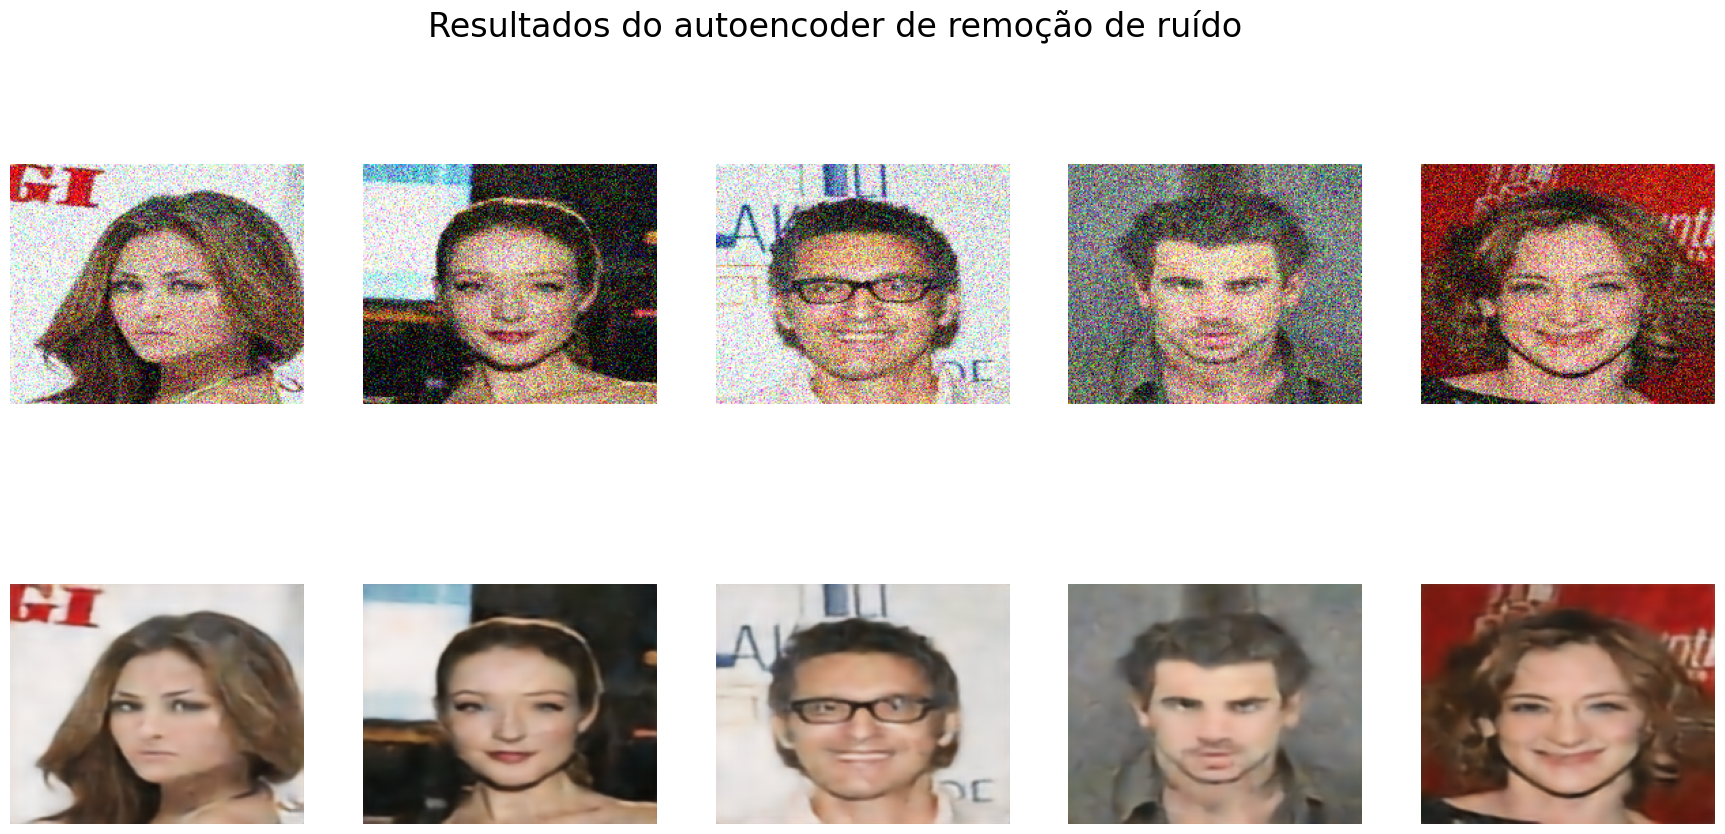

In [211]:
samples = fixed_samples + np.random.normal(loc=0., scale=.2, size=fixed_samples.shape)
samples = np.clip(samples, 0., 1.)

plt.figure(figsize=(22, 10))
for i, (im, _) in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  decoded = denoising_autoencoder.predict(im, verbose=False)

  plt.suptitle('Resultados do autoencoder de remoção de ruído', fontsize=24)

  plt.subplot(2, 5, i+1)
  plt.imshow(tf.reshape(im, (176, 216, 3)))
  plt.axis('off')

  plt.subplot(2, 5, i+6)
  plt.imshow(tf.reshape(decoded, (176, 216, 3)).numpy().astype('float32'))
  plt.axis('off')

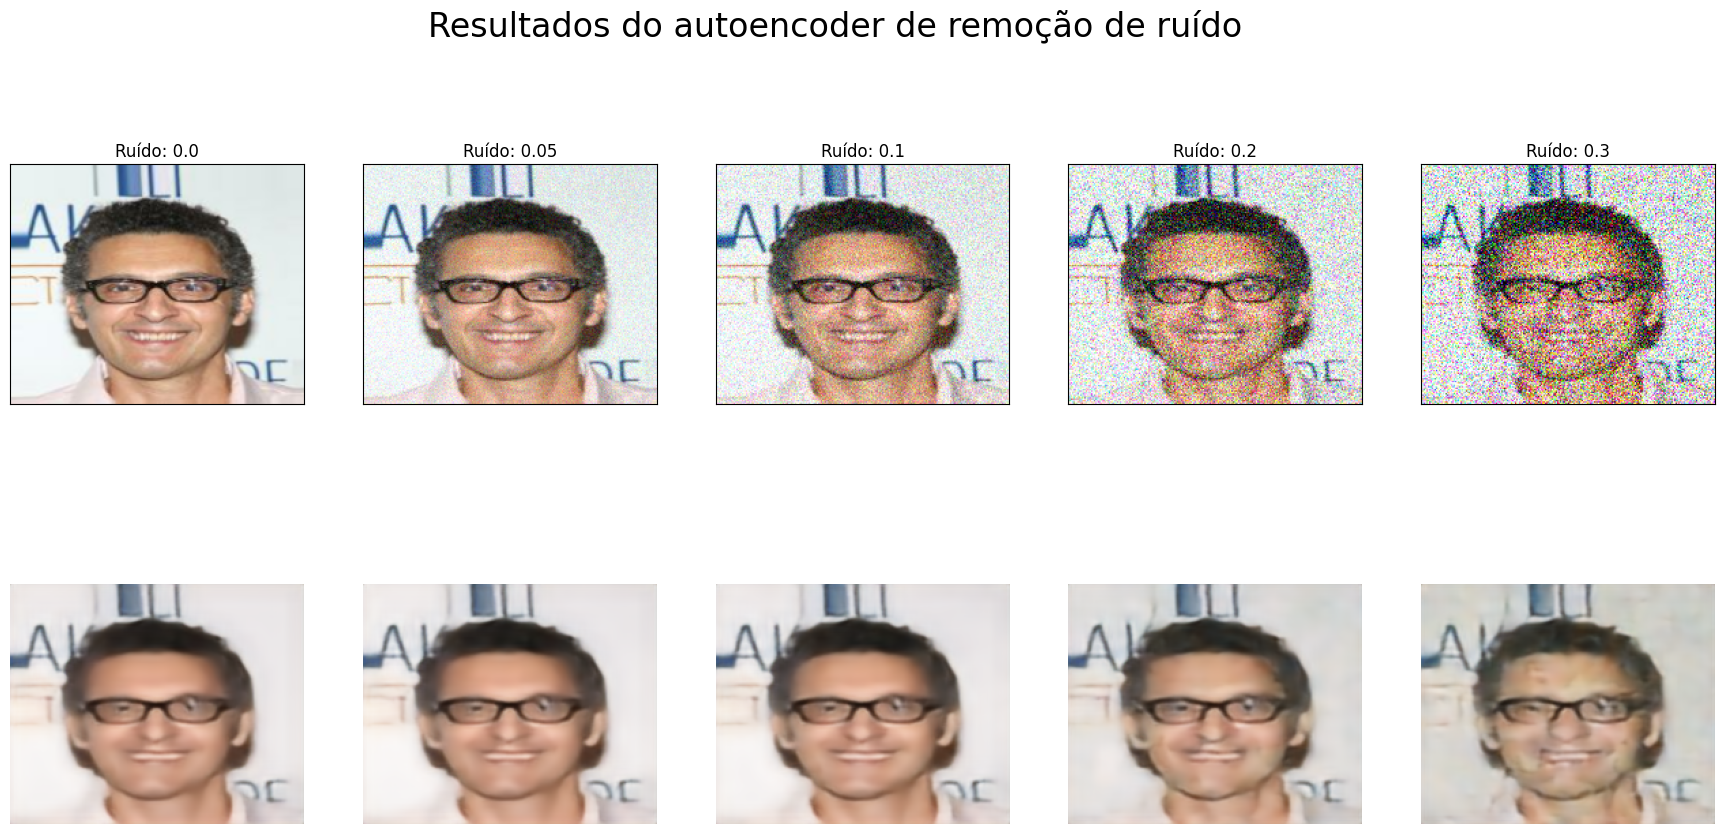

In [212]:
noise_values = [0., .05, .1, .2, .3]
image, _ = fixed_samples[2]
samples = [image+np.random.normal(loc=0., scale=i, size=image.shape) for i in noise_values]

plt.figure(figsize=(22, 10))
for i, im in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  im = np.clip(im, 0., 1.)
  decoded = denoising_autoencoder.predict(im, verbose=False)

  plt.suptitle('Resultados do autoencoder de remoção de ruído', fontsize=24)

  plt.subplot(2, 5, i+1)
  plt.imshow(tf.reshape(im, (176, 216, 3)))
  plt.title(f'Ruído: {noise_values[i]}')
  plt.xticks(())
  plt.yticks(())

  plt.subplot(2, 5, i+6)
  plt.imshow(tf.reshape(decoded, (176, 216, 3)).numpy().astype('float32'))
  plt.axis('off')

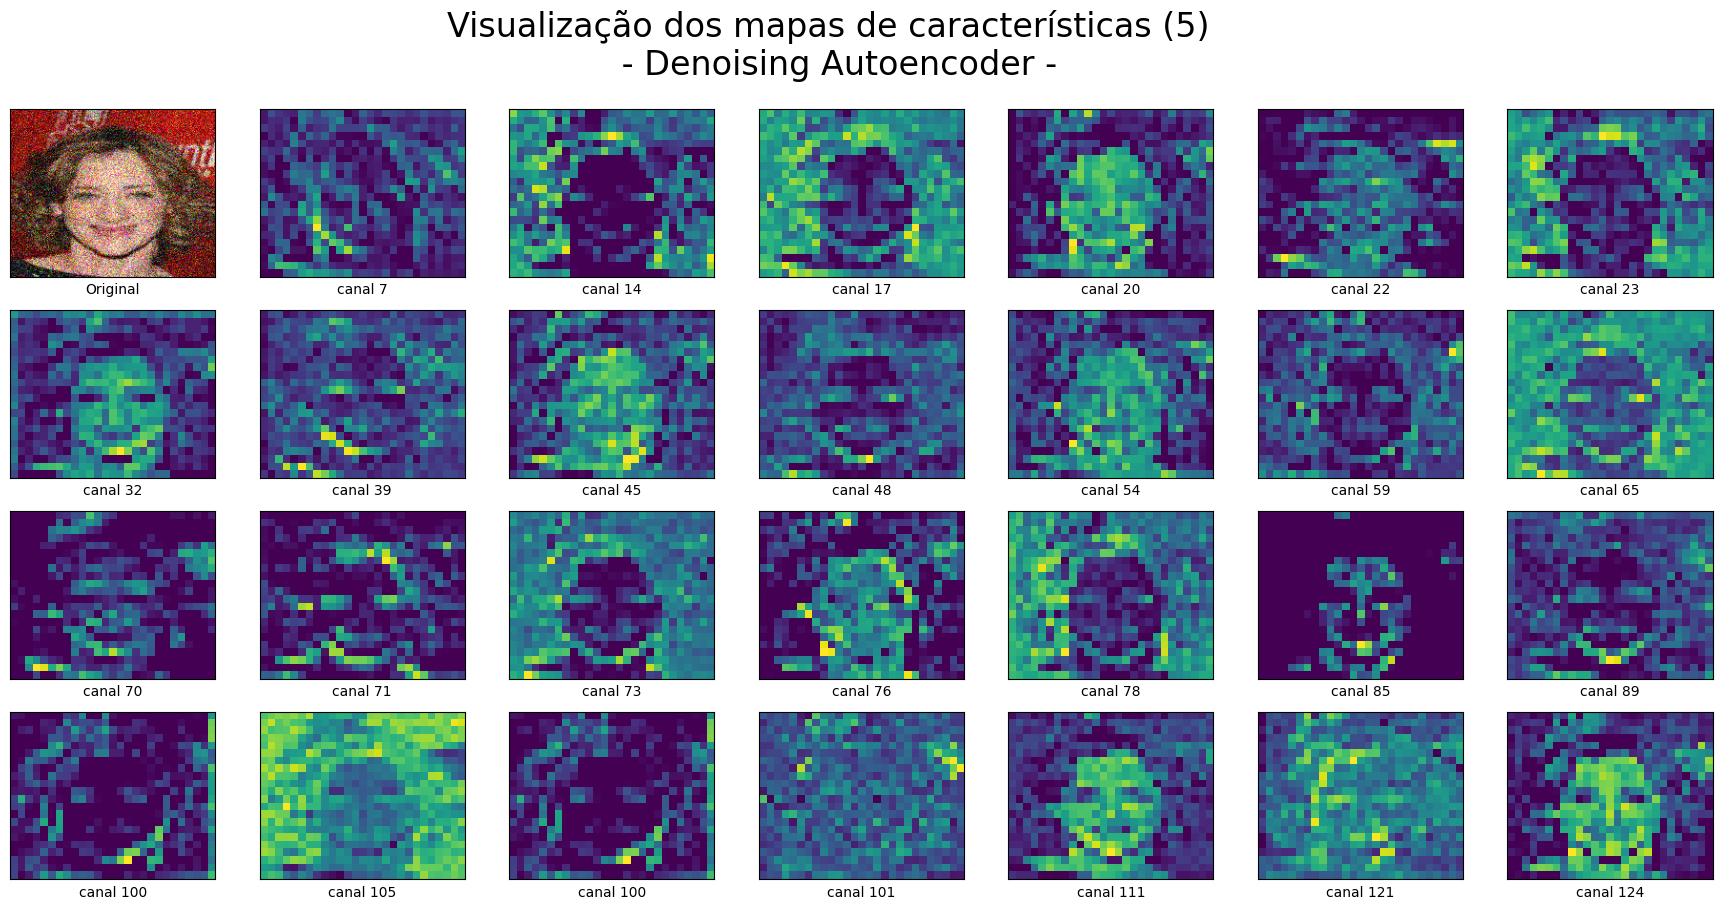

In [207]:
sample = fixed_samples[4] + np.random.normal(loc=0., scale=.2, size=fixed_samples[0].shape)
sample = np.clip(sample, 0., 1.)

original = tf.reshape(sample[0], (176, 216, 3))

n = 27
latent = encoder.predict(sample, verbose=False)[0] # Mapa de características
canais = [7,   14,  17,  20,  22,  23, 32,
          39,  45,  48,  54,  59,  65, 70,
          71,  73,  76,  78,  85,  89, 100,
          105, 100, 101, 111, 121, 124
         ]

plt.figure(figsize=(22, 10))

# Imagem original
plt.suptitle('Visualização dos mapas de características (5) \n - Denoising Autoencoder -', fontsize=24)
plt.subplot(4, 7, 1)
plt.imshow(original)
plt.xlabel(f'Original')
plt.xticks(())
plt.yticks(())

# Canais
for i, c in enumerate(canais):
  plt.subplot(4, 7, i+2)
  plt.imshow(latent[:, :, c].reshape(22, 27), cmap='viridis')
  plt.xlabel(f'canal {c}')
  plt.xticks(())
  plt.yticks(())

In [132]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

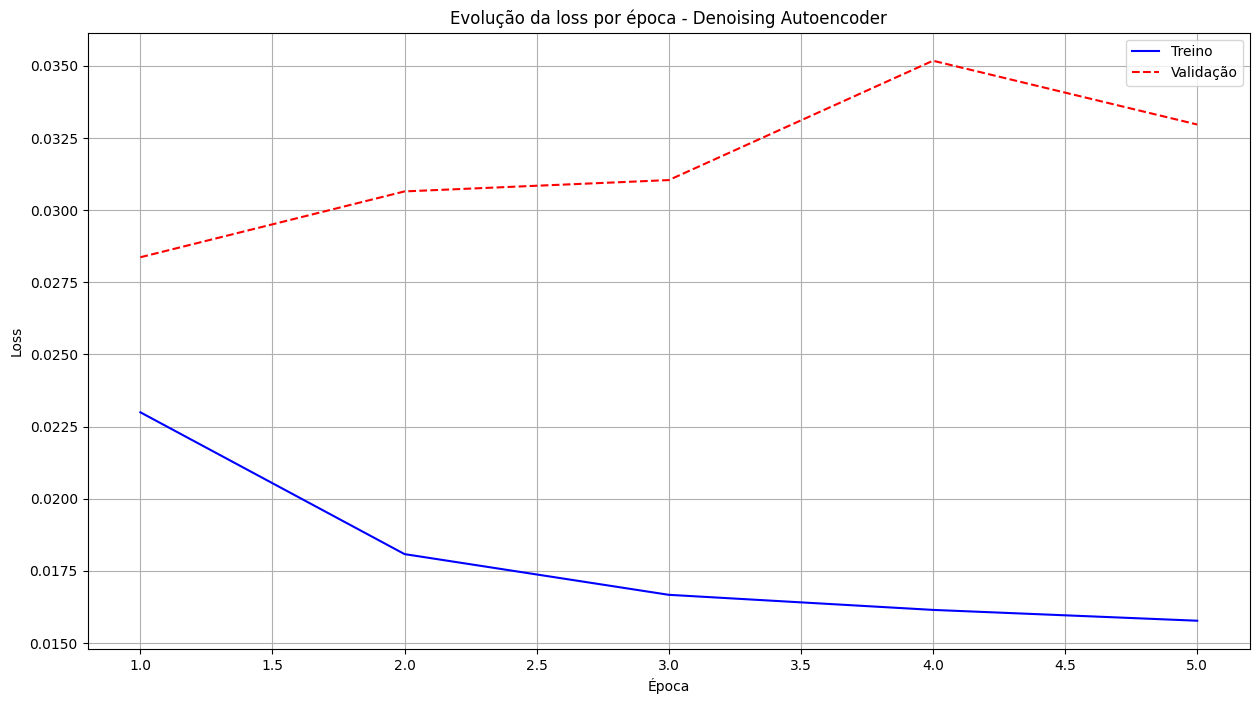

In [133]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, loss, 'b-', label='Treino')
plt.plot(epochs, val_loss, 'r--', label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da loss por época - Denoising Autoencoder')
plt.legend()
plt.grid(True)
plt.show();